In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import time
import datetime
from dateutil import parser
import matplotlib.dates as mdates
import matplotlib.ticker as plticker

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM


In [71]:
Final_df = pd.read_csv('crypto_data_tweet_final.csv',index_col=1)
Final_df = Final_df.drop('Unnamed: 0', axis=1)
Final_df

,1INCHBUSD_open,1INCHBUSD_high,1INCHBUSD_low,1INCHBUSD_close,1INCHBUSD_volume,1INCHUSD_open,1INCHUSD_high,1INCHUSD_low,1INCHUSD_close,1INCHUSD_volume,...,Tweet,Username,Location,Favorites,Retweets,Followers,Postive,Negative,Neutral,Compound
datetime_x,,,,,,,,,,,,,,,,,,,,,
2022-01-01 00:00:00,2.410,2.450,2.406,2.429,27034.1,2.390,2.420,2.390,2.420,47726.30,...,Bitcoin solves a 300 trillion problem and is v...,BitcoinSapiens,21 Million Citadels,1908,249,16180,0.220,0.119,0.661,0.3182
2022-01-01 01:00:00,2.434,2.441,2.421,2.424,15641.5,2.420,2.440,2.410,2.440,109643.15,...,Some statistics to start the year During 2021 ...,DigiEconomist,NaN,50793,18615,14240,0.101,0.000,0.899,0.5574
2022-01-01 02:00:00,2.423,2.444,2.418,2.434,10500.5,2.430,2.450,2.430,2.440,22534.85,...,Asset prices go parabolic and your pay stays s...,thelevelupexp,Orange Coin,1289,229,4722,0.129,0.043,0.828,0.4215
2022-01-01 03:00:00,2.433,2.449,2.433,2.435,11621.9,2.430,2.450,2.430,2.430,16066.99,...,1 In 2013 I wrote this piece on how Bitcoin ca...,VitalikButerin,Earth,3294,307,4155547,0.155,0.000,0.845,0.6908
2022-01-01 04:00:00,2.436,2.454,2.415,2.428,18122.9,2.420,2.430,2.400,2.400,35143.16,...,Don t tell me Bitcoin wealth is centralized wh...,Dennis_Porter_,"Oregon, USA",3016,330,115305,0.221,0.000,0.779,0.6249
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-31 19:00:00,0.967,0.972,0.953,0.964,62571.4,0.966,0.972,0.966,0.969,34241.32,...,In the future a bitcoin will likely be worth a...,SpencerKSchiff,NaN,6023,423,141978,0.087,0.000,0.913,0.2263
2022-05-31 20:00:00,0.963,0.965,0.960,0.965,19140.8,0.969,0.970,0.966,0.968,5846.26,...,Bitcoin trying for a reversal like,CryptoCronkite,NaN,26829,5674,24352,0.385,0.000,0.615,0.3612
2022-05-31 21:00:00,0.964,0.964,0.958,0.961,15210.7,0.969,0.970,0.967,0.969,5068.87,...,If the dip keeps dipping At least we will have...,TotemFi,Web 3.0,2394,242,22931,0.000,0.000,1.000,0.0000


In [72]:
Final_df = Final_df[['BTCUSDT_open','BTCUSDT_high','BTCUSDT_low', 'BTCUSDT_close', 'BTCUSDT_volume', 'LTCUSD_close', 
                     'LTCUSD_volume', 'ETHUSD_close', 'ETHUSD_volume','ETHUSD_open','Postive','Negative','Neutral','Compound']]

In [73]:
dataset = Final_df.values
dataset = dataset.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
#print('dataset.shape', dataset.shape)
num_of_features = len(Final_df.columns)
print('Number of features', num_of_features)

Number of features 14


In [100]:
expr_name = 'expr_4'
look_back = 24*30 
lstm_layers = 64
epochs=5
batch_size=128

In [101]:
train_size_percent = 0.80
pred_col = Final_df.columns.get_loc('BTCUSDT_close')

# function to split the data
def create_dataset(dataset, pred_col, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), :]
        dataX.append(a)
        dataY.append(dataset[i + look_back, pred_col])
    return np.array(dataX), np.array(dataY)


train_size = int(len(dataset) * train_size_percent)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]

trainX, trainY = create_dataset(train, pred_col, look_back=look_back)
testX, testY = create_dataset(test, pred_col, look_back=look_back)
# reshape input to be  [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], look_back, num_of_features))
testX = np.reshape(testX, (testX.shape[0],look_back, num_of_features))

print('Training dataset length ', len(train))
print('Testing dataset length ', len(test))
print('look_back ', look_back)

Training dataset length  2899
Testing dataset length  725
look_back  720


In [102]:
# create and fit the LSTM network

model = Sequential()
model.add(LSTM(lstm_layers, input_shape=(look_back,num_of_features)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history= model.fit(trainX, trainY,validation_split=0.30, epochs=epochs, batch_size=batch_size,shuffle=False)

Epoch 1/5
12/12 [==============================] - 2s 82ms/step - loss: 0.0856 - val_loss: 0.0049
Epoch 2/5
12/12 [==============================] - 1s 53ms/step - loss: 0.0118 - val_loss: 0.0063
Epoch 3/5
12/12 [==============================] - 1s 53ms/step - loss: 0.0098 - val_loss: 0.0037
Epoch 4/5
12/12 [==============================] - 1s 56ms/step - loss: 0.0042 - val_loss: 0.0044
Epoch 5/5
12/12 [==============================] - 1s 55ms/step - loss: 0.0037 - val_loss: 0.0027


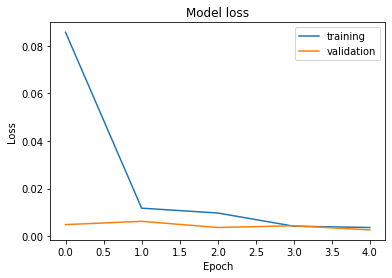

In [103]:
# Plot training
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

In [104]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# Get something which has as many features as dataset
trainPredict_extended = np.zeros((len(trainPredict),num_of_features))
# Put the predictions there
trainPredict_extended[:,pred_col] = trainPredict[:,0]
# Inverse transform it and select the 3rd column.
trainPredict = scaler.inverse_transform(trainPredict_extended) [:,pred_col]

# Get something which has as many features as dataset
testPredict_extended = np.zeros((len(testPredict),num_of_features))
# Put the predictions there
testPredict_extended[:,pred_col] = testPredict[:,0]
# Inverse transform it and select the pred_col column.
testPredict = scaler.inverse_transform(testPredict_extended)[:,pred_col] 

trainY_extended = np.zeros((len(trainY),num_of_features))
trainY_extended[:,pred_col]=trainY
trainY = scaler.inverse_transform(trainY_extended)[:,pred_col]

testY_extended = np.zeros((len(testY),num_of_features))
testY_extended[:,pred_col]=testY
testY = scaler.inverse_transform(testY_extended)[:,pred_col]

# calculate root mean squared error
trainScore_RMSE = math.sqrt(mean_squared_error(trainY, trainPredict))
testScore_RMSE = math.sqrt(mean_squared_error(testY, testPredict))

# calculate absolute mean error
trainScore_MAE = np.sum(np.absolute(trainY - trainPredict))/len(trainY)
testScore_MAE = np.sum(np.absolute(testY - testPredict))/len(testY)

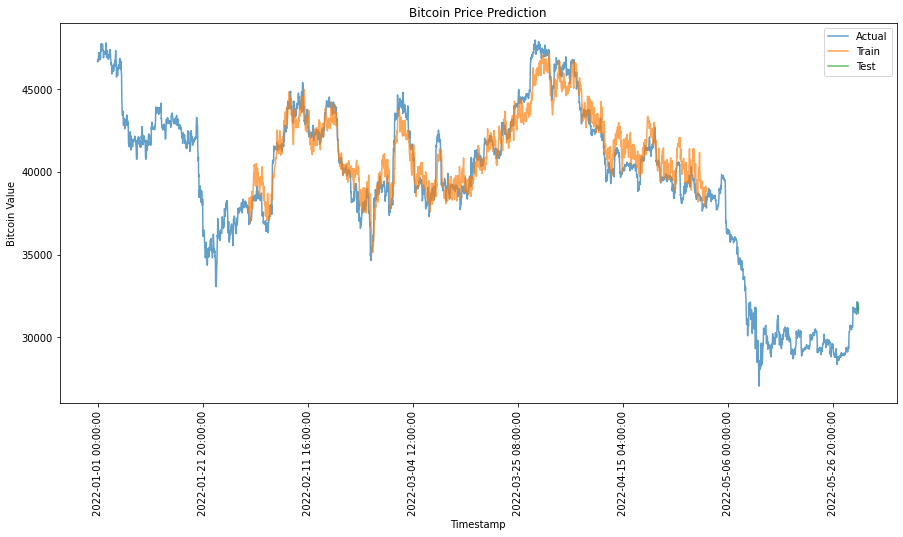

In [105]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, pred_col] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, pred_col] = testPredict

# contruct pandas dataframe for plotting
time_df = pd.DataFrame(Final_df.index)
time_df['Actual'] = scaler.inverse_transform(dataset)[:,pred_col]
df1 = pd.DataFrame(trainPredictPlot[:,pred_col],columns=['Train'])
df2 = pd.DataFrame(testPredictPlot[:,pred_col],columns=['Test'])
time_df2 = pd.concat([time_df, df1, df2], axis=1, sort=False)
time_df2.set_index('datetime_x',inplace=True)

# plot the output
fig, ax = plt.subplots(figsize=(15,7))
time_df2.plot(ax=ax,rot=90,alpha=0.7)
plt.xlabel('Timestamp')
plt.ylabel('Bitcoin Value')
plt.title('Bitcoin Price Prediction')
plt.savefig(expr_name + '.png',bbox_inches = "tight")

In [106]:
print('-' * 50)
print('Experiment name:', expr_name)

print('-' * 50)
print('look_back days:', look_back/24)
print('lstm_layers:', lstm_layers)
print('epochs:', epochs)
print('batch_size:', batch_size)
print('dataset features', list(Final_df.columns))


print('-' * 50)
print('Train Score: %.2f RMSE' % (trainScore_RMSE))
print('Test Score: %.2f RMSE' % (testScore_RMSE))

print('-' * 50)
print('Train Score: %.2f MAE' % (trainScore_MAE))
print('Test Score: %.2f MAE' % (testScore_MAE))

print('-' * 50)
print('Model summary:')
model.summary()

--------------------------------------------------
Experiment name: expr_4
--------------------------------------------------
look_back days: 30.0
lstm_layers: 64
epochs: 5
batch_size: 128
dataset features ['BTCUSDT_open', 'BTCUSDT_high', 'BTCUSDT_low', 'BTCUSDT_close', 'BTCUSDT_volume', 'LTCUSD_close', 'LTCUSD_volume', 'ETHUSD_close', 'ETHUSD_volume', 'ETHUSD_open', 'Postive', 'Negative', 'Neutral', 'Compound']
--------------------------------------------------
Train Score: 1030.97 RMSE
Test Score: 326.24 RMSE
--------------------------------------------------
Train Score: 835.89 MAE
Test Score: 294.50 MAE
--------------------------------------------------
Model summary:
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 64)                20224     
                                                                 
 dense_14 (Dense)            (No